In [31]:
# Global imports and settings
from __future__ import print_function
from __future__ import division

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

import numpy as np
np.set_printoptions(precision=3)

<center>
    <img src="img/scikit-learn-logo.png" width="40%" />
    <br />
    <h1>An introduction to Machine Learning with Scikit-Learn</h1>
    <br /><br />
    Gilles Louppe (<a href="https://twitter.com/glouppe">@glouppe</a>), April 23, 2015
    <br /><br />
    <a href="https://github.com/glouppe/tutorial-sklearn-lhcb">https://github.com/glouppe/tutorial-sklearn-lhcb</a>
</center>

# About myself 

* PhD in machine learning, expertise in tree-based methods
* Core developer of Scikit-Learn
* Research Fellow working in GS-SIS, on graph and text mining problems
* Open to collaborations

# Outline

* What is machine learning?
* Scikit-Learn
* Classifying events with tree-based methods
* Model evaluation and selection
* Ensemble methods
* Model persistence
* Going further

# What is machine learning?

Predict, understand or identify patterns in data from observations.

Applications include: _Natural language processing, Computer vision, IR and advertisement, Robotics, Bioinformatics, __High Energy Physics__, ..._

<center><img src="img/motivation.png" width="70%" /></center>

# Scikit-Learn

## Overview

* Machine learning library written in __Python__
* __Simple and efficient__, for both experts and non-experts
* Classical, __well-established machine learning algorithms__
* Shipped with <a href="http://scikit-learn.org/dev/documentation.html">documentation</a> and <a href="http://scikit-learn.org/dev/auto_examples/index.html">examples</a>
* __BSD 3 license__

## Community driven development

- 10-15~ core developers (mostly researchers)
- 250+ occasional contributors
- __All working together__ on [GitHub](https://github.com/scikit-learn/scikit-learn)
- Emphasis on __keeping the project maintainable__
    - Style consistency
    - Unit-test coverage
    - Documentation and examples
    - Code review

## Python stack for data analysis

- The __open source__ Python ecosystem provides __a standalone, versatile and powerful scientific working environment__, including: [NumPy](http://numpy.org), [SciPy](http://scipy.org), [IPython](http://ipython.org), [Matplotlib](http://matplotlib.org), [Pandas](http://pandas.pydata.org/), _and many others..._
- Core algorithms are implemented in low-level languages;
- Scikit-Learn builds upon NumPy and SciPy and __complements__ this scientific environment with machine learning algorithms;
- By design, Scikit-Learn is __non-intrusive__, easy to use and easy to combine with other libraries.

<center> 
<img src="img/scikit-learn-logo.png" style="max-width: 120px; display: inline" />
<img src="img/numpy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/scipy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/ipython-logo.jpg" style="max-width: 120px; display: inline" />
<img src="img/matplotlib-logo.png" style="max-width: 120px; display: inline"/>
<img src="img/pandas-logo.png" style="max-width: 120px; display: inline" />
</center>

## Algorithms

__Supervised learning:__

* Linear models (Ridge, Lasso, Elastic Net, ...)
* Ensemble methods (Random Forests, Bagging, GBRT, ...)
* Support Vector Machines
* Nearest neighbors
* Neural networks (soon!)

<center><img src="img/classifiers.png" />
<em>A comparison of (some of the) classifiers in Scikit-Learn</em></center><br />

__Unsupervised learning:__

* Clustering (KMeans, Ward, ...)
* Matrix decomposition (PCA, ICA, ...)
* Density estimation
* Outlier detection

__Model selection and evaluation:__

* Cross-validation
* Grid-search
* Lots of metrics

_... and many more!_ (See our [Reference](http://scikit-learn.org/stable/modules/classes.html))

# Classifying events with tree-based methods

### Supervised learning framework

## Decision trees

### Loading data

In [2]:
# Download data from https://archive.ics.uci.edu/ml/datasets/SUSY

# Load CSV file with pandas
import pandas as pd 
df = pd.read_csv("SUSY.csv", header=None)     
df.columns = ["target", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", 
              "lepton 2 pT", "lepton 2 eta", "lepton 2 phi", 
              "missing energy magnitude", "missing energy phi", "MET_rel", 
              "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", 
              "dPhi_r_b", "cos(theta_r1)"]
df.target = df.target.astype(int)

### Exploration and visualization with `pandas`

In [22]:
df.head()  # df.describe(), df.info(), ...

,target,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


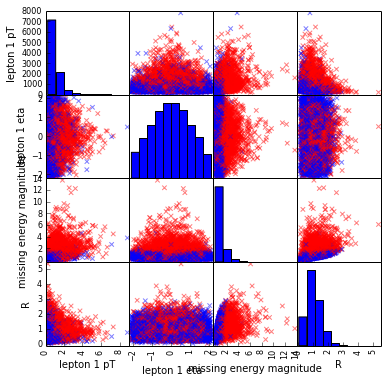

In [73]:
df_sample = df[:10000]
colors = ["blue",  # 0 = background
          "red"]   # 1 = signal
features = ["lepton 1 pT", "lepton 1 eta", "missing energy magnitude", "R"]

_ = pd.scatter_matrix(df_sample[features], marker="x", 
                      c=df_sample.target.apply(lambda x: colors[x]))

Need more? See `pandas` <a href="http://pandas.pydata.org/pandas-docs/stable/visualization.html">visualization</a> documentation.

### Data format in scikit-learn

All scikit-learn objects takes as input __data which is structured as Numpy arrays or sparse matrices__. 

TODO: motivate this choice

In [71]:
# Get data as Numpy arrays from the pandas data frame
X = df_sample.drop("target", axis=1).values
y = df_sample.target.values

print(X[:3])
print(X.shape)
print(X.dtype)

[[ 0.973  0.654  1.176  1.157 -1.74  -0.874  0.568 -0.175  0.81  -0.253
   1.922  0.89   0.411  1.146  1.933  0.994  1.368  0.041]
 [ 1.668  0.064 -1.225  0.506 -0.339  1.673  3.475 -1.219  0.013  3.775
   1.046  0.568  0.482  0.     0.448  0.205  1.322  0.378]
 [ 0.445 -0.134 -0.71   0.452 -1.614 -0.769  1.22   0.504  1.831 -0.431
   0.526  0.942  1.588  2.024  0.603  1.562  1.135  0.181]]
(10000, 18)
float64


### A simple and unified API

All objects in scikit-learn share a uniform and limited API consisting of three complementary interfaces:

- an `estimator` interface for building and fitting models;
- a `predictor` interface for making predictions;
- a `transformer` interface for converting data.

### Estimators

An estimator is any object that learns from data; it may be a classification, regression or clustering algorithm or a transformer that extracts/filters useful features from raw data.

In [40]:
class Estimator(object):
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self
            
    def predict(self, X):
        """Predict response of ``X``."""
        # compute predictions ``pred``
        return pred

In [58]:
# Import estimator class 
from sklearn.tree import DecisionTreeClassifier

# Set hyper-parameters, for controlling the learning algorithm
clf = DecisionTreeClassifier(max_depth=5, criterion="entropy")

# Learn a model from training data
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [65]:
# Estimator state is stored in instance attributes
clf.tree_

### Predictors

In [59]:
# Make predictions 
print(clf.predict(X[:3]))

[0 1 0]


In [60]:
# Compute class probabilities
print(clf.predict_proba(X[:3]))

[[ 0.657  0.343]
 [ 0.     1.   ]
 [ 0.778  0.222]]


# Model evaluation and selection

## Selection versus evaluation

## Cross-validation

## Parameter search

## Under/over-fitting

- plot
- regularization

# Ensemble methods

## Random Forests

## Boosting

## Interpretation

- var importances
- partial dependence plots

# Model persistence

# Going further

- Add references to tutorials, packages, etc